In [1]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image 

In [2]:
class CompleteGraph():
    def __init__(self, nodes=100):
        self._num_of_nodes = nodes
        self._g = nx.Graph()
        self._nodes = []
        
    def generate(self):
        self._nodes = list(range(0, self._num_of_nodes))
        self._g.add_nodes_from(self._nodes)
        for i in range(len(self._nodes)):
            for j in range(i+1, len(self._nodes)):
                if self._nodes[i] != self._nodes[j] and not self._g.has_edge(self._nodes[i], self._nodes[j]):
                     self._g.add_edge(self._nodes[i], self._nodes[j])            
        return self._g

In [3]:
class RandomGraph():
    def __init__(self, nodes=100):
        self._num_of_nodes = nodes
        self._g = nx.Graph()
        self._nodes = []
        
    def generate(self, p = 0.5):
        self._nodes = list(range(0, self._num_of_nodes))
        self._g.add_nodes_from(self._nodes)
        for i in range(len(self._nodes)):
            for j in range(i+1, len(self._nodes)):
                if self._nodes[i] != self._nodes[j] and np.random.uniform(0, 1) < p and not self._g.has_edge(self._nodes[i], self._nodes[j]):
                     self._g.add_edge(self._nodes[i], self._nodes[j])            
        return self._g

In [4]:
class WattsStrogatzModel():
    def __init__(self, nodes=100):
        self._num_of_nodes = nodes
        self._g = nx.Graph()
        self._nodes = []
        self._K = 0
        self._p = 0

    def generate_ring(self, K):
        self._nodes = list(range(0, self._num_of_nodes))
        for n in self._nodes:
            for i in range(1, K+1):
                self._g.add_edge(n, self._nodes[n-i])
        return self._g
    
    def generate(self, p=0.1, K=4):
        self._K = K
        self._p = p
        K = K/2
        if int(K) != K:
            raise Exception('K must me an even number')
        self.generate_ring(int(K))
        for i in range(len(self._nodes)):
            ns = self._g.neighbors(self._nodes[i])
            for n in list(ns):
                if self._nodes[i] < n:
                    if np.random.uniform(0, 1) < p:
                        new_connection = self._nodes[random.randint(0, self._num_of_nodes-1)]
                        while (new_connection == self._nodes[i] or self._g.has_edge(self._nodes[i], new_connection)):
                            new_connection = self._nodes[random.randint(0, self._num_of_nodes-1)]
                        self._g.add_edge(self._nodes[i], new_connection)
                        self._g.remove_edge(self._nodes[i], n)
        return self._g

In [5]:
class BarabasiAlbertModel():
    def __init__(self, nodes=100):
        self._num_of_nodes = nodes
        self._nodes = []
        self._g = nx.Graph()
      
    def startup(self, m_0=4):
        self._nodes = list(range(0, m_0))
        for n1 in self._nodes:
            for n2 in self._nodes:
                if n1 != n2:
                    self._g.add_edge(n1, n2)
        return self._g
                    
    def generate(self, m_0=4, m=4):
        self.startup(m_0)
        for i in range(m_0, self._num_of_nodes):
            degrees = [val for (node, val) in self._g.degree()]
            deg_sum = sum(degrees)
            ps = [self._g.degree(j)/deg_sum for j in self._nodes]
            new_neighbors = random.choices(self._nodes, weights=ps, k=m+1)
            edges = [(i, new_neighbors[j]) for j in range(len(new_neighbors))]
            self._g.add_edges_from(edges)
            self._nodes.append(i)
        return self._g


In [6]:
class BassABM:
    def __init__(self, p, q, graph):
        self.p = p
        self.q = q
        self.graph = graph
        self.initial_state(graph)
        self.M = self.graph.number_of_nodes()

    def initial_state(self, graph):
        for node in graph.nodes:
            graph.nodes[node]["state"] = 0

    def get_neighbors_states(self, node):
        neighbors = self.graph.neighbors(node)
        states = [self.graph.nodes[neighbor]["state"] for neighbor in neighbors]
        return states
    
    def bass_diffusion_model(self, max_iters = 60):
        fraction_of_adopted = np.zeros(max_iters)
        for i in range(max_iters):
            nodes = list(self.graph.nodes)
            new_states = list(nx.get_node_attributes(self.graph, "state").values())
            for node in nodes:
                p_sum = (np.sum(self.get_neighbors_states(node)))
                switch_probability = (self.p + p_sum*self.q/self.M) * (1-self.graph.nodes[node]["state"])

                if np.random.uniform() < switch_probability:
                    new_states[node] = 1
                    self.graph.nodes[node]["state"] = 1
            fraction_of_adopted[i] = np.sum(new_states)/len(new_states)
        return np.diff(fraction_of_adopted), fraction_of_adopted

In [7]:
MC_STEPS = 100
max_steps = 100
Ps = [0.01, 0.03, 0.05]
Qs = [0.01, 0.03, 0.05]

In [8]:
def get_bass_results(graph, p, q, MC_steps=MC_STEPS, max_iterations=max_steps):
    freq_new = list(np.zeros(MC_steps))
    freq = list(np.zeros(MC_steps))
    for i in range(MC_steps):
        bass = BassABM(p, q, graph)
        freq_new_adopted, freq_adopted = bass.bass_diffusion_model(max_iterations)
        freq_new[i] = freq_new_adopted
        freq[i] = freq_adopted
    freq_new_avg = np.mean(np.array(freq_new), axis=0)
    freq_avg = np.mean(np.array(freq), axis=0)
    return freq_new_avg, freq_avg

In [9]:
def generate_graph(graph_type):
    match graph_type:
        case "CG":
            return CompleteGraph().generate()
        case "RG":
            return RandomGraph().generate()
        case "WSM":
            return WattsStrogatzModel().generate()
        case "BAM":
            return BarabasiAlbertModel().generate()
        case "RRG":
            return nx.random_regular_graph(d=4, n=100)
        case default:
            raise ValueError("Graph type must be a string from ['CG', 'RG', 'WSM', 'BAM', 'RRG']")

In [10]:
def get_results(graph_types=['CG', 'RG', 'WSM', 'BAM', 'RRG'], ps=Ps, qs=Qs, MC_steps=MC_STEPS, max_iterations=max_steps):
    if len(ps) != 3 or len(qs) != 3:
        raise ValueError("Parameters lists must be of len equal to three")
    else:
        result_dict = {}
        for p in ps:
            for q in qs:
                for graph_type in graph_types:
                    print(f"p: {p}, q: {q}, graph_type: {graph_type}")
                    graph = generate_graph(graph_type)
                    results = get_bass_results(graph, p, q, MC_steps, max_iterations)
                    result_dict[f"p_{p}q_{q}k{graph_type}"] = results

    return result_dict


In [13]:
def create_subplots(results, graph_types=['CG', 'RG', 'WSM', 'BAM', 'RRG'], ps=Ps, qs=Qs, max_iterations=100):
    if len(ps) != 3 or len(qs) != 3:
        raise ValueError("Parameters lists must be of len equal to three")
    else:
        markers = ['*', '.', 'D', 'P', '1']
        fig1, axs1 = plt.subplots(nrows=3, ncols=3, figsize=(13, 13))
        fig2, axs2 = plt.subplots(nrows=3, ncols=3, figsize=(13, 13))
        for i, p in enumerate(ps):
            for j, q in enumerate(qs):
                for k, graph_type in enumerate(graph_types):
                    result = results[f"p_{p}q_{q}k{graph_type}"]
                    axs1[i, j].plot(range(max_iterations-1), result[0], marker=markers[k], label=f"{graph_type}")
                    axs2[i, j].plot(range(max_iterations), result[1], marker=markers[k], label=f"{graph_type}")
                    axs1[i, j].set_title(rf"$p={p}, q={q}$")
                    axs2[i, j].set_title(rf"$p={p}, q={q}$")
        fig1.suptitle('Frequency of newly adapted in time')
        fig2.suptitle('Frequency of adapted in time')   
        handles1, labels1 = axs1[0, 0].get_legend_handles_labels()
        handles2, labels2 = axs2[0, 0].get_legend_handles_labels()
        fig1.legend(handles1, labels1, loc='upper right')
        fig2.legend(handles2, labels2, loc='upper right')
        fig1.text(0.5, 0.04, 'Time', ha='center')
        fig1.text(0.04, 0.5, 'Freq', va='center', rotation='vertical')
        fig2.text(0.5, 0.04, 'Time', ha='center')
        fig2.text(0.04, 0.5, 'Freq', va='center', rotation='vertical')
    fig1.savefig(f"images/freq_new_adapted3.png")
    fig2.savefig(f"images/freq_adapted3.png")

## Results

In [93]:
res = get_results(graph_types=['CG', 'RG', 'WSM', 'BAM', 'RGG'], ps=Ps, qs=Qs, MC_steps=100, max_iterations=max_steps)

p: 0.01, q: 0.1, graph_type: CG
p: 0.01, q: 0.1, graph_type: RG
p: 0.01, q: 0.1, graph_type: WSM
p: 0.01, q: 0.1, graph_type: BAM
p: 0.01, q: 0.1, graph_type: RGG
p: 0.01, q: 0.3, graph_type: CG
p: 0.01, q: 0.3, graph_type: RG
p: 0.01, q: 0.3, graph_type: WSM
p: 0.01, q: 0.3, graph_type: BAM
p: 0.01, q: 0.3, graph_type: RGG
p: 0.01, q: 0.5, graph_type: CG
p: 0.01, q: 0.5, graph_type: RG
p: 0.01, q: 0.5, graph_type: WSM
p: 0.01, q: 0.5, graph_type: BAM
p: 0.01, q: 0.5, graph_type: RGG
p: 0.03, q: 0.1, graph_type: CG
p: 0.03, q: 0.1, graph_type: RG
p: 0.03, q: 0.1, graph_type: WSM
p: 0.03, q: 0.1, graph_type: BAM
p: 0.03, q: 0.1, graph_type: RGG
p: 0.03, q: 0.3, graph_type: CG
p: 0.03, q: 0.3, graph_type: RG
p: 0.03, q: 0.3, graph_type: WSM
p: 0.03, q: 0.3, graph_type: BAM
p: 0.03, q: 0.3, graph_type: RGG
p: 0.03, q: 0.5, graph_type: CG
p: 0.03, q: 0.5, graph_type: RG
p: 0.03, q: 0.5, graph_type: WSM
p: 0.03, q: 0.5, graph_type: BAM
p: 0.03, q: 0.5, graph_type: RGG
p: 0.05, q: 0.1, graph

In [12]:
res_new = get_results(graph_types=['CG', 'RG', 'WSM', 'BAM', 'RRG'], ps=Ps, qs=Qs, MC_steps=200, max_iterations=100)

p: 0.01, q: 0.01, graph_type: CG
p: 0.01, q: 0.01, graph_type: RG
p: 0.01, q: 0.01, graph_type: WSM
p: 0.01, q: 0.01, graph_type: BAM
p: 0.01, q: 0.01, graph_type: RRG
p: 0.01, q: 0.03, graph_type: CG
p: 0.01, q: 0.03, graph_type: RG
p: 0.01, q: 0.03, graph_type: WSM
p: 0.01, q: 0.03, graph_type: BAM
p: 0.01, q: 0.03, graph_type: RRG
p: 0.01, q: 0.05, graph_type: CG
p: 0.01, q: 0.05, graph_type: RG
p: 0.01, q: 0.05, graph_type: WSM
p: 0.01, q: 0.05, graph_type: BAM
p: 0.01, q: 0.05, graph_type: RRG
p: 0.03, q: 0.01, graph_type: CG
p: 0.03, q: 0.01, graph_type: RG
p: 0.03, q: 0.01, graph_type: WSM
p: 0.03, q: 0.01, graph_type: BAM
p: 0.03, q: 0.01, graph_type: RRG
p: 0.03, q: 0.03, graph_type: CG
p: 0.03, q: 0.03, graph_type: RG
p: 0.03, q: 0.03, graph_type: WSM
p: 0.03, q: 0.03, graph_type: BAM
p: 0.03, q: 0.03, graph_type: RRG
p: 0.03, q: 0.05, graph_type: CG
p: 0.03, q: 0.05, graph_type: RG
p: 0.03, q: 0.05, graph_type: WSM
p: 0.03, q: 0.05, graph_type: BAM
p: 0.03, q: 0.05, graph_ty

### Graph parameters used:
RG: $p = 0.5$

WSM: $K = 4$, $p = 0.1$

BAM: $k_0 = 4$, $k = 4$

RRG: $d=4$ 

### Results for 100 time steps averaged over 200 repetitions

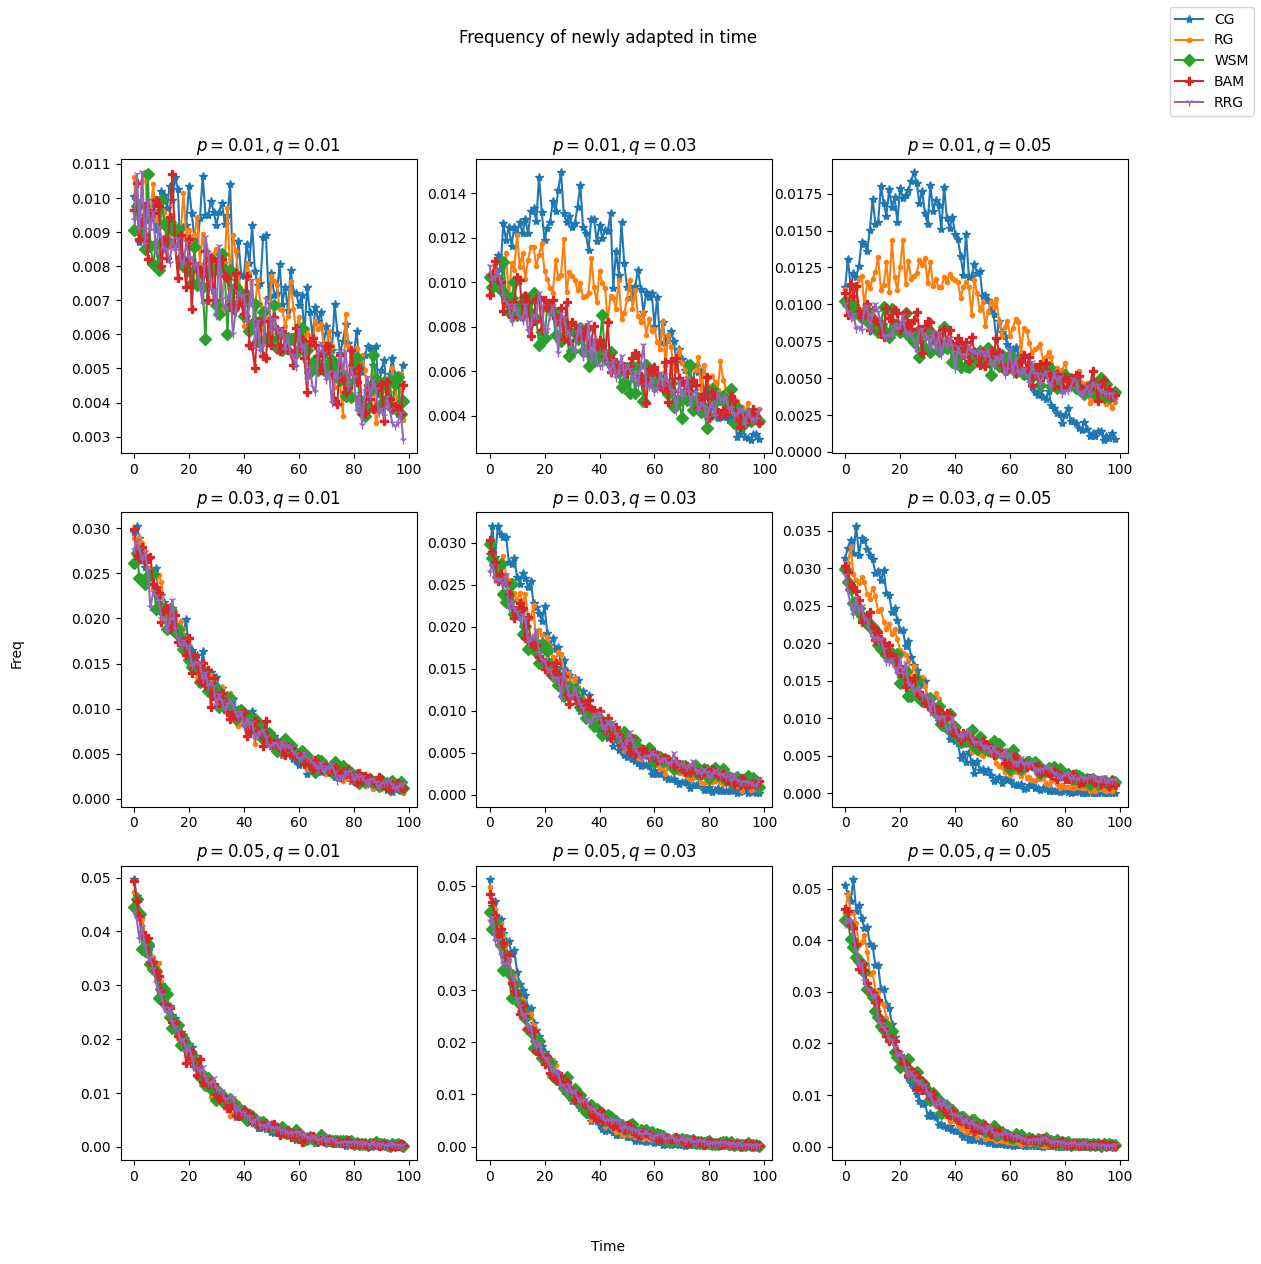

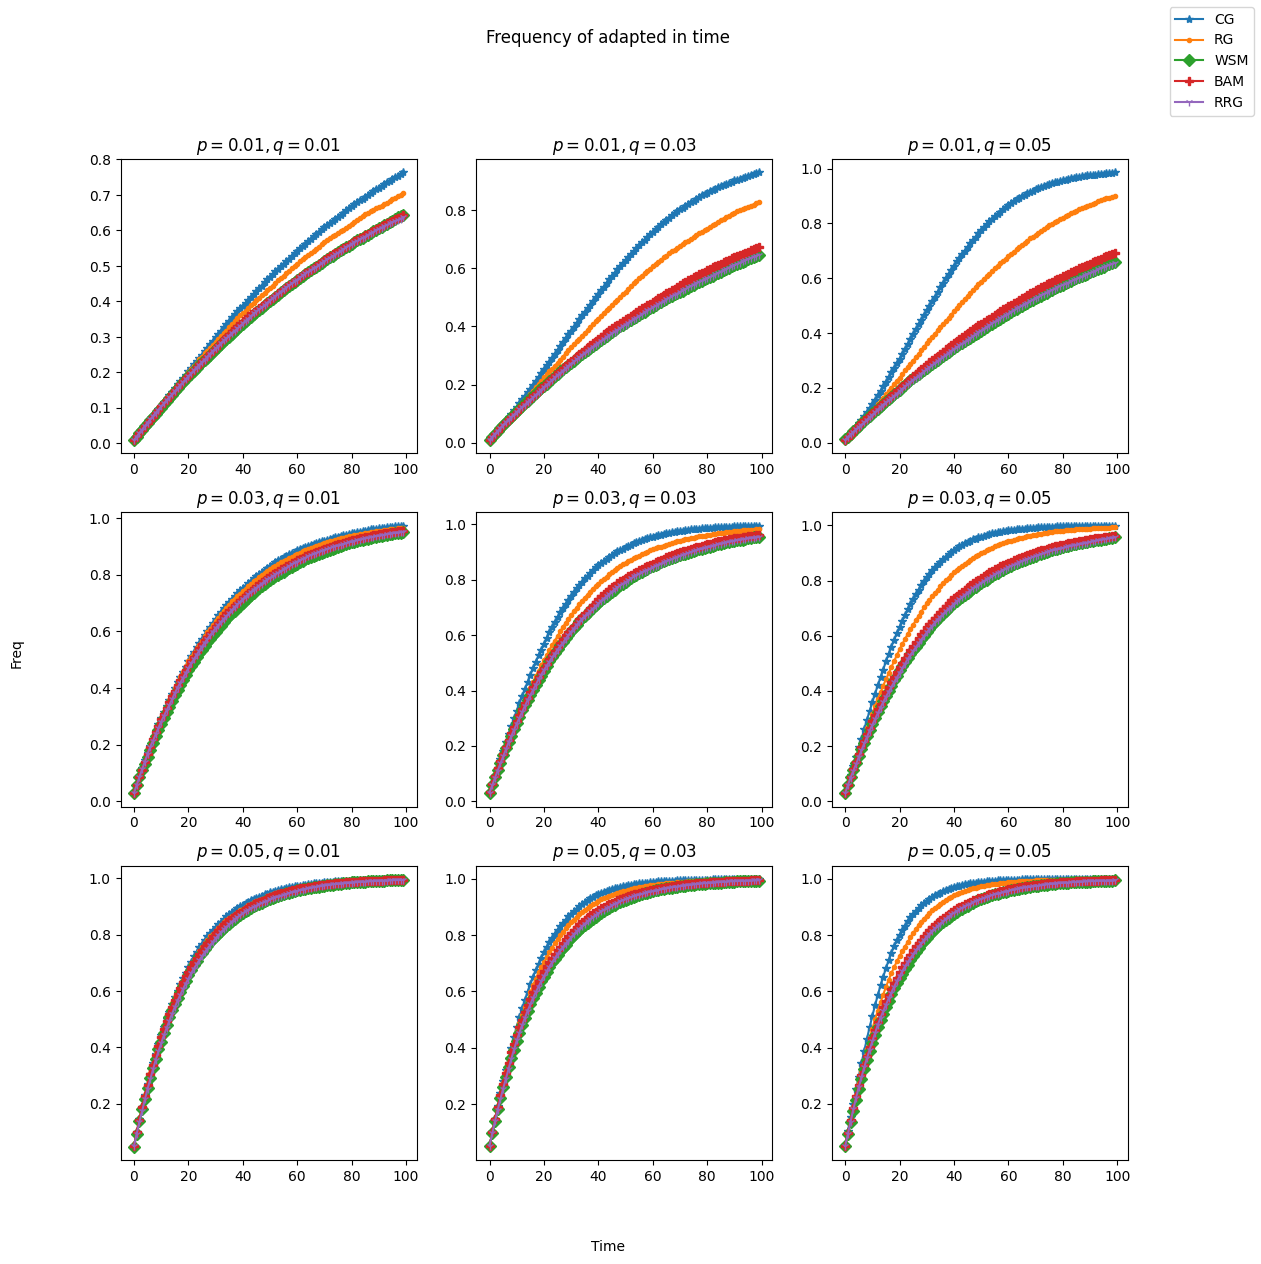

In [14]:
create_subplots(res_new)

In [3]:
Image(url="images/freq_adapted3.png", width=800, height=800) 

In [4]:
Image(url="images/freq_new_adapted3.png", width=800, height=800) 

### Results for 100 time steps averaged over 100 repetitions

In [5]:
Image(url="images/freq_adapted2.png", width=800, height=800) 

In [6]:
Image(url="images/freq_new_adapted2.png", width=800, height=800) 